Column names in dataset: Index(['Longitude', 'Latitude', 'Speed', 'Distance', 'Time', 'Acc X', 'Acc Y',
       'Acc Z', 'Heading', 'gyro_x', 'gyro_y', 'gyro_z', 'label',
       'Acc_Magnitude', 'Acc_Change', 'Gyro_Magnitude', 'Gyro_Change',
       'Net_Displacement', 'Speed_Change', 'Heading_Change',
       'Rolling_Acc_Mean', 'Rolling_Acc_STD', 'acc_mean', 'acc_std',
       'gyro_mean', 'gyro_std'],
      dtype='object')
Dataset head:
   Longitude   Latitude  Speed  Distance                 Time     Acc X  \
0  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12  0.046402   
1  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12 -0.136978   
2  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.045355   
3  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13  0.242089   
4  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.230234   

      Acc Y     Acc Z  Heading    gyro_x  ...  Gyro_Change  Net_Displacement  \
0 -0.137178 -0.282934      35

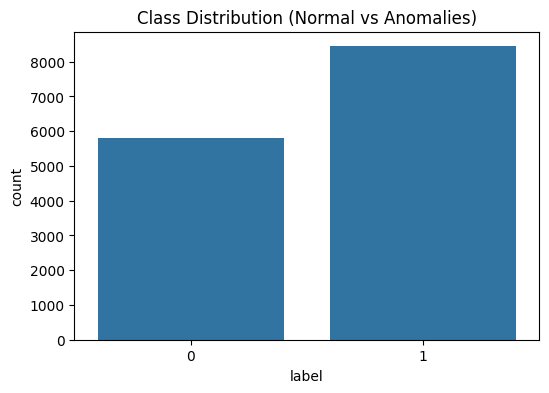

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Featured_dataset.csv')

# Check column names
print("Column names in dataset:", data.columns)

# Set the target label column name
target_column = 'label'  # Adjusted to match the actual column name

# Ensure the target column exists
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset. Please verify the column name.")

# Dataset Overview
print("Dataset head:")
print(data.head())

# Class Distribution Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column, data=data)
plt.title("Class Distribution (Normal vs Anomalies)")
plt.show()

# Feature Distribution (Pairplot for visual inspection)
sns.pairplot(data, hue=target_column)
plt.show()

# Separate features and target label
X = data.drop(columns=[target_column])  # Features
y = data[target_column]                 # Target (Label)

# Feature Engineering (Remove any non-numeric columns like timestamps)
X = X.select_dtypes(include=[np.number])  # Keep only numeric features

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Selection and Training
# Isolation Forest
model_if = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
model_if.fit(X_train)

# Predict on Test Set
y_pred_test_if = model_if.predict(X_test)
y_pred_test_if = [1 if x == -1 else 0 for x in y_pred_test_if]  # Convert to 1 for anomaly, 0 for normal

# Evaluation Metrics and Visualization Function
def evaluate_performance(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC-AUC:", roc_auc)
    print("Confusion Matrix:\n", cm)

    # Metrics Visualization (Bar Chart)
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc}
    plt.figure(figsize=(8, 4))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.title(f"{model_name} Performance Metrics")
    plt.show()

    # Confusion Matrix Heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate Isolation Forest
evaluate_performance(y_test, y_pred_test_if, model_name="Isolation Forest")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test_if)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Isolation Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve (Isolation Forest)")
plt.legend()
plt.show()

# Hyperparameter Tuning for Isolation Forest (optional)
# Define a custom scoring function for GridSearchCV
def custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred)

# Hyperparameter grid for tuning
param_grid = {'n_estimators': [50, 100, 150], 'max_samples': ['auto', 0.7, 0.9]}

# Initialize GridSearchCV with the custom scorer
grid_search = GridSearchCV(IsolationForest(contamination='auto', random_state=42),
                           param_grid,
                           scoring=make_scorer(custom_scorer),
                           cv=3)  # 3-fold cross-validation

# Fit grid search
grid_search.fit(X_train)

# Print the best parameters from the grid search
print("\nBest Parameters for Isolation Forest:", grid_search.best_params_)

# Insights - Identify patterns in detected anomalies
data['Predictions'] = model_if.predict(X)
data['Predictions'] = data['Predictions'].apply(lambda x: 1 if x == -1 else 0)  # Convert predictions
anomalies = data[data['Predictions'] == 1]  # Filter out anomalies
print("\nAnomalies Overview:")
print(anomalies.describe())  # Summary statistics of anomalies

# Visualize Anomalies by Feature Means
plt.figure(figsize=(10, 6))
sns.heatmap(anomalies.describe().transpose(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Feature Overview for Detected Anomalies")
plt.show()
